In [24]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import time
import atexit
import random
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)


class BookRecommendation(object):

    def __init__(self, verbose=0):
        """
        params:
            verbose -> int
                if verbose > 0:
                    print progress
        """
        init_timer = time.time()
        self.df_r, self.df_b, self.df_bt, self.df_t = self._load_df(verbose=verbose)
        self.corr = self._init_corr(verbose=verbose)
        self.title_series = self.df_b["title"]
        if verbose > 0:
            print("Time to init:", time.time() - init_timer, "sec")
        self.base_update = False
        # use atexit if you want to update the database at the end of script
        #atexit.register(self.exit)
        #self.rating_mean = self.df_r["rating"].mean()
        self.rating_mean = 2.5

        
    def update_database(self):
        if self.base_update:
            df_r.to_csv("ratings.csv", index=False)
            self.base_update=False
    
    
    def exit(self):
        self.update_database()
        

    def _load_df(self, verbose=0):
        if verbose > 0:
            print("Loading ratings.csv ...")
        df_r = pd.read_csv('ratings.csv')
        df_r.sort_values(by="user_id", inplace=True, ignore_index=True)
        df_r = df_r.reset_index(drop=True)
        if verbose > 0:
            print("Done")
            print("Loading books.csv ...")
        df_b = pd.read_csv('books.csv')
        if verbose > 0:
            print("Done")
            print("Loading book_tags.csv ...")
        df_bt = pd.read_csv('book_tags.csv')
        if verbose > 0:
            print("Done")
            print("Loading tags.csv ...")
        df_t = pd.read_csv('tags.csv')
        if verbose > 0:
            print("Done")
        return df_r, df_b, df_bt, df_t


    def _init_corr(self, verbose=0):
        if verbose > 0:
            print("Loading matrix ...")
        df_r_pivot = self.df_r.pivot(index="book_id", columns ="user_id", values="rating")
        df_r_pivot = df_r_pivot.fillna(0)
        X = df_r_pivot.values
#         if verbose > 0:
#             print("Done")
#             print("Fiting SVD ...")
        # SVD = TruncatedSVD(n_components=n_components, random_state=42)
        # matrix = SVD.fit_transform(X)
        if verbose > 0:
            print("Done")
            print("Loading corr ...")
        #corr = np.corrcoef(matrix)
        corr = np.corrcoef(X)
        if verbose > 0:
            print("Done")
        return corr
        

    def show_book_title_from_id(self, book_id):
        book_title = self.df_b.loc[self.df_b["book_id"] == book_id, "title"].values[0]
        print(book_id, book_title)


    def show_books(self, start, end):
        while start < end and start < len(self.title_series):
            print("book_id", start+1, "title", self.title_series[start])
            start += 1


    def related_books(self, book, n_books=10, unwanted_id=[]):
        idx = []
        if type(book) == str:
            book_id = self.df_b.loc[self.df_b["title"] == book, "book_id"].values[0]
        elif type(book) == int:
            book_id = book
        else:
            return idx
        
        book_corr = self.corr[book - 1]
        idx = (-book_corr).argsort()
        
        i = 0
        while i < len(idx):
            idx[i] += 1
            i += 1

        new_idx = []
        i = 0
        while len(new_idx) < n_books and i < len(idx):
            if idx[i] not in unanted_id:
                new_idx.append(idx[i])
            i += 1
            
        return new_idx


    def show_books_from_user_id(self, user_id):
        df_user = self.df_r[self.df_r["user_id"] == user_id]
        df_user = df_user.sort_values(by="rating", ascending=False, ignore_index=True)
        for i in df_user.index:
            print(self.df_b[self.df_b["book_id"] == df_user["book_id"][i]]["title"].values[0], df_user["rating"][i])


    def recommend_books_from_user_id(self, user_id, n_books=100):
        """
        Recommend books for a user in our database.
        If he's not in our database we're recommanding typical best rated books
        params:
            user_id -> int
            n_books -> int; n_books >= 1
        """
        
        # get ratings of user
        df_user = self.df_r[self.df_r["user_id"] == user_id]
        
        # size of list we wanna create; we're gonna return n_books value randomly inside
        book_list_size = n_books * 3
        
        # if user didn't read any book return typical best rated books
        if len(df_user) == 0:
            book_list = self.popularity_recommender(book_list_size)
            # shuffle
            random.shuffle(book_list)
            return book_list[:n_books]
        
        # sort books rated by user by rating (descending)
        df_user = df_user.sort_values(by="rating", ascending=False, ignore_index=True)
        
        # get list of id of books rated by user
        user_read_books = df_user["book_id"].values.tolist()
        
        # count how many books the user liked (liked means: rating >= average_all_ratings)
        liked_books = df_user[df_user["rating"] >= self.rating_mean].count()
    
        # for each book liked, we're recommanding others books the user didn't read already
        # these books are the most related with books the user liked the most
        stars_count = []
        for i in range(0, 5):
            stars_count.append(len(df_user[df_user["rating"] == i + 1]))

        min_accepted = int(np.ceil(self.rating_mean))
        
        i = 0
        while min_accepted + i <= 5:
            if stars_count[min_accepted + i - 1] > 0:
                min_rated_in_accepted_ratings = min_accepted + i
                break
            i += 1
            
        denominator = 0
        i = 0
        while min_accepted + i <= 5:
            denominator += stars_count[min_accepted + i - 1] * np.power(2, i)
            i += 1
            
        print("self.rating_mean", self.rating_mean)
        
        book_list = []
        i = 0
        while i < len(df_user.index):
            if df_user["rating"][df_user.index[i]] < self.rating_mean:
                break
                
            nominator = np.power(2, df_user["rating"][df_user.index[i]] - min_rated_in_accepted_ratings)
            wanted_n_books = int(np.ceil(nominator * (book_list_size / denominator)))
            
            print("actual stars", df_user["rating"][df_user.index[i]])
            print("nominator", nominator)
            print("denominator", denominator)
            print("wanted_n_books non rounded", nominator * (book_list_size / denominator))
            print("wanted_n_books rounded", wanted_n_books)
            
            book_list += self.related_books(book=df_user["book_id"][df_user.index[i]],
                                            n_books=wanted_n_books, unwanted_id=book_list+user_read_books)
            i += 1
                
        if len(book_list) < book_list_size:
            book_list += self.popularity_recommender(n_books=book_list_size-len(book_list), unwanted_id=book_list+user_read_books)
            
        # shuffle
        random.shuffle(book_list)

        return book_list[:n_books]
    
    
    def popularity_recommender(self, n_books=50, unwanted_id=[]):
        # goal: create a dataframe of weighted ratings for each book, and return the 
        # indexes of the n_books best rated books.
        # (v*R + m*C) / (v+m)
        # v: number of votes for the book
        # m: minimum number of votes required to appear in the list
        # R: average rating of the book
        # C: mean value of all the votes
        # create a pandas Dataframe with book_id and the number of ratings for the book
        df_wr = self.df_r[["book_id", "rating"]].groupby("book_id", as_index=False).count().rename(columns={"rating": "v"})
        # add the mean score for each book
        df_wr["R"] = self.df_r[["book_id", "rating"]].groupby("book_id", as_index=False).mean()["rating"]
        # let m be the median of the numbers of votes (248)
        m = df_wr["v"].quantile(0.90)
        # print(m)
        C = self.df_r["rating"].mean()
        # compute the weighted ratings for each books
        df_wr["wr"] = df_wr.apply(lambda row: (row["v"]*row["R"] + m*C) / (row["v"] + m), axis=1)
        # sort the books by their weighted ratings
        df_wr = df_wr.sort_values(by="wr", ascending=False, ignore_index=True).reset_index(drop=True)
        book_list = []
        i = 0
        while len(book_list) < n_books and i < len(df_wr):
            if df_wr["book_id"][i] not in unwanted_id:
                book_list.append(df_wr["book_id"][i])
            i += 1
        return book_list

    
    def add_ratings(self, user_id, book_id, rating):
        """
         if user doesn't exist -> create user
        """
        if len(book_id) == 0 or len(book_id) != len(rating):
            # print("wrong params")
            return
        
        if self.df_r[self.df_r["user_id"] == user_id].shape[0] > 0:
            # if user already exist
            # drop doublons
            all_books = self.df_r[self.df_r["user_id"] == user_id]["book_id"].values.tolist()
            known_books = []
            for i in all_books:
                if i in book_id:
                    known_books.append(i)
            i = 0
            while i < len(book_id):
                if book_id[i] in known_books:
                    book_id.pop(i)
                    rating.pop(i)
                    i -= 1
                i += 1
            if len(book_id) == 0 or len(book_id) != len(rating):
                return
            # and then add book_id and ratings on known user
        
        _dict = {"user_id": [user_id]*len(book_id), "book_id": book_id, "rating": rating}
        df = pd.DataFrame(data=_dict)
        self.df_r = self.df_r.append(df, ignore_index=True)
        self.base_update = True

        
    def del_user(self, user_id):
        self.df_r = self.df_r.drop(self.df_r[self.df_r["user_id"] == user_id].index)
        self.df_r.reset_index(drop=True)

In [25]:
book_recommendation = BookRecommendation(verbose=1)

Loading ratings.csv ...
Done
Loading books.csv ...
Done
Loading book_tags.csv ...
Done
Loading tags.csv ...
Done
Loading matrix ...
Done
Loading corr ...
Done
Time to init: 81.25961589813232 sec


In [26]:
def show_books(start=0, end=10):
    print("\n", str(" "+str(start)+" ").center(50, "-"))
    book_recommendation.show_books(start, end)
    print(str(" "+str(end)+" ").center(50, "-"), "\n")

    
def show_related_books(book_id, n_books=10):
    book_recommendation.show_book_title_from_id(book_id)
    book_list = book_recommendation.related_books(book=book_id, n_books=n_books)
    print("\n", " 0 ".center(50, "-"))
    for i in book_list:
        book_recommendation.show_book_title_from_id(i)
    print("\n", str(" "+str(n_books)+" ").center(50, "-"))
    
    
def show_user(user_id):
    book_recommendation.show_books_from_user_id(user_id)

    
def recommend_user(user_id, n_books=10):
    print("\n", " already read ".center(50, "-"))
    book_recommendation.show_books_from_user_id(user_id)
    print("\n", " end ".center(50, "-"))
    print("\n", " recommendations ".center(50, "-"))
    book_list = book_recommendation.recommend_books_from_user_id(user_id, n_books=n_books)
    print("nb_books", len(book_list))
    for i in book_list:
        book_recommendation.show_book_title_from_id(i)
    print("\n", " end ".center(50, "-"))

    
def add_ratings(user_id=1000000, book_id=[1], rating=[5]):
    book_recommendation.add_ratings(user_id, book_id, rating)
    
    
def del_user(user_id=1000000):
    book_recommendation.del_user(user_id)

In [27]:
#show_books(0, 10)
#show_related_books(1, n_books=10)
add_ratings(user_id=1000000, book_id=[1, 2, 3, 4, 5], rating=[3, 5, 5, 4, 5])
show_user(user_id=1000000)
#del_user(user_id=1000000)
recommend_user(1000000, n_books=10)

Harry Potter and the Sorcerer's Stone (Harry Potter, #1) 5
Twilight (Twilight, #1) 5
The Great Gatsby 5
To Kill a Mockingbird 4
The Hunger Games (The Hunger Games, #1) 3

 ------------------ already read ------------------
Harry Potter and the Sorcerer's Stone (Harry Potter, #1) 5
Twilight (Twilight, #1) 5
The Great Gatsby 5
To Kill a Mockingbird 4
The Hunger Games (The Hunger Games, #1) 3

 ---------------------- end -----------------------

 ---------------- recommendations -----------------
self.rating_mean 2.5
actual stars 5
nominator 4
denominator 15
wanted_n_books non rounded 8.0
wanted_n_books rounded 8
actual stars 5
nominator 4
denominator 15
wanted_n_books non rounded 8.0
wanted_n_books rounded 8
actual stars 5
nominator 4
denominator 15
wanted_n_books non rounded 8.0
wanted_n_books rounded 8
actual stars 4
nominator 2
denominator 15
wanted_n_books non rounded 4.0
wanted_n_books rounded 4
actual stars 3
nominator 1
denominator 15
wanted_n_books non rounded 2.0
wanted_n_books 

# K-means clusters to recommend similar books acoording to their tags

- create a matrix with tags as the columns and books as the lines
- fill the matrix with 1 if the book is associated with the tag, 0 if not
- train a k-means model on the books
- find best number of clusters with elbow method

every book in the same cluster can be recommended together

## creation of sparse matrix

In [28]:
df_bt_2 = pd.merge(left=book_recommendation.df_bt, right=book_recommendation.df_t, how="left", on="tag_id")
display(df_bt_2.sort_values(by="count", ascending=False).loc[df_bt_2["count"] < 0])
df_bt_2[["tag_name", "count"]].groupby("tag_name", as_index=False).count().sort_values(by="count", ascending=False).head(10)
# pd.DataFrame.sort_values?

,goodreads_book_id,tag_id,count,tag_name
959611,22931009,9221,-1,default
922052,18607805,21619,-1,no-audio
922051,18607805,10197,-1,ebook
922055,18607805,2272,-1,america-in-retreat
922054,18607805,6552,-1,challenge-2013
922053,18607805,17246,-1,kindle-library


,tag_name,count
30574,to-read,9983
11557,favorites,9881
22743,owned,9858
5207,books-i-own,9799
8717,currently-reading,9776
18045,library,9415
22753,owned-books,9221
11743,fiction,9097
30521,to-buy,8692
17213,kindle,8316


In [29]:
idx = list(book_recommendation.df_bt.loc[book_recommendation.df_bt["count"] < 0].index.values)
df_bt_2 = book_recommendation.df_bt.drop(labels=idx)
display(len(book_recommendation.df_bt), len(df_bt_2), df_bt_2)

999912

999906

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


In [30]:
display(df_bt_2.groupby(["goodreads_book_id", "tag_id"]).count().value_counts())
# there is 8 duplicates in df_bt_3

count
1        999890
2             8
dtype: int64

In [31]:
df_TEMP = df_bt_2.groupby(["goodreads_book_id", "tag_id"], as_index=False).count()
df_TEMP.loc[df_TEMP["count"] == 2]

,goodreads_book_id,tag_id,count
263,3,22743,2
159373,22369,25148,2
265103,52629,2928,2
265121,52629,10094,2
265135,52629,13272,2
265137,52629,13322,2
308746,77449,15169,2
308770,77449,25148,2


In [32]:
for book_id, tag_id in zip(df_TEMP.loc[df_TEMP["count"] == 2]["goodreads_book_id"], df_TEMP.loc[df_TEMP["count"] == 2]["tag_id"]):
    display(df_bt_2.loc[(df_bt_2["goodreads_book_id"] == book_id) & (df_bt_2["tag_id"] == tag_id)])
# la plupart des lignes qui se dédoublent on un count similaire ; on se contente de supprimer les doublons (goodreads_book_id, tag_id)

,goodreads_book_id,tag_id,count
208,3,22743,6066
209,3,22743,6065


,goodreads_book_id,tag_id,count
159370,22369,25148,4
159371,22369,25148,4


,goodreads_book_id,tag_id,count
265139,52629,2928,1
265140,52629,2928,1


,goodreads_book_id,tag_id,count
265127,52629,10094,1
265128,52629,10094,1


,goodreads_book_id,tag_id,count
265154,52629,13272,1
265155,52629,13272,1


,goodreads_book_id,tag_id,count
265186,52629,13322,1
265187,52629,13322,1


,goodreads_book_id,tag_id,count
308762,77449,15169,8
308767,77449,15169,7


,goodreads_book_id,tag_id,count
308770,77449,25148,7
308771,77449,25148,7


In [33]:
df_bt_2.drop_duplicates(subset=["goodreads_book_id", "tag_id"], inplace=True)

In [34]:
df_bt_pivot = df_bt_2.pivot(index="goodreads_book_id", columns ="tag_id", values="count").fillna(0)
df_bt_pivot
# add all ratings
# add language
# delete tags that tag less than n books
# delete all tags that have a low count
# PCA / SVD ?
# feature selection ?

tag_id,0,1,2,3,4,5,6,7,8,9,...,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31538647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31845516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32075671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
display(df_bt_pivot)
# access book 5 tag 6
display(df_bt_pivot[6][33288638])

tag_id,0,1,2,3,4,5,6,7,8,9,...,34242,34243,34244,34245,34246,34247,34248,34249,34250,34251
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31538647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31845516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32075671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0.0

In [35]:
display(df_bt_pivot.columns.values, df_bt_pivot.index.values, type(df_bt_pivot))

array([    0,     1,     2, ..., 34249, 34250, 34251])

array([       1,        2,        3, ..., 32075671, 32848471, 33288638])

pandas.core.frame.DataFrame

In [39]:
# add all ratings to df_bt
# display(book_recommendation.df_b[["goodreads_book_id", "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5"]])
df_bt_3 = df_bt_2.rename(columns={"tag_id": "columns", "count": "value"})
display(df_bt_3)

# pivot that df with multiple columns
ratings_to_add = {
    "goodreads_book_id": [],
    "columns": [],
    "value": []
}

df_TEMP = book_recommendation.df_b[["goodreads_book_id", "ratings_1", "ratings_2", "ratings_3", "ratings_4", "ratings_5", "language_code"]]
display("df_TEMP:", df_TEMP, "df_TEMP dummies:", pd.get_dummies(df_TEMP))

df_language_code_dummies = pd.get_dummies(df_TEMP[["goodreads_book_id", "language_code"]])
display("df_language_code_dummies:", df_language_code_dummies)

for index in df_TEMP.index:
    
    # add ratings_1
    ratings_to_add["goodreads_book_id"].append(df_TEMP.loc[index, "goodreads_book_id"])
    ratings_to_add["columns"].append("ratings_1")
    ratings_to_add["value"].append(df_TEMP["ratings_1"][index])
    
    # add ratings_2
    ratings_to_add["goodreads_book_id"].append(df_TEMP["goodreads_book_id"][index])
    ratings_to_add["columns"].append("ratings_2")
    ratings_to_add["value"].append(df_TEMP["ratings_2"][index])
    
    # add ratings_3
    ratings_to_add["goodreads_book_id"].append(df_TEMP["goodreads_book_id"][index])
    ratings_to_add["columns"].append("ratings_3")
    ratings_to_add["value"].append(df_TEMP["ratings_3"][index])
    
    # add ratings_4
    ratings_to_add["goodreads_book_id"].append(df_TEMP["goodreads_book_id"][index])
    ratings_to_add["columns"].append("ratings_4")
    ratings_to_add["value"].append(df_TEMP["ratings_4"][index])
    
    # add ratings_5
    ratings_to_add["goodreads_book_id"].append(df_TEMP["goodreads_book_id"][index])
    ratings_to_add["columns"].append("ratings_5")
    ratings_to_add["value"].append(df_TEMP["ratings_5"][index])
    
    for column in df_language_code_dummies.columns:
        if column == "goodreads_book_id":
            continue
        ratings_to_add["goodreads_book_id"].append(df_TEMP["goodreads_book_id"][index])
        ratings_to_add["columns"].append(column)
        ratings_to_add["value"].append(df_language_code_dummies[column][index])

df_bt_3 = df_bt_3.append(pd.DataFrame.from_dict(ratings_to_add))
df_bt_3

,goodreads_book_id,columns,value
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
999907,33288638,21303,7
999908,33288638,17271,7
999909,33288638,1126,7
999910,33288638,11478,7


'df_TEMP:'

,goodreads_book_id,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,language_code
0,2767052,66715,127936,560092,1481305,2706317,eng
1,3,75504,101676,455024,1156318,3011543,eng
2,41865,456191,436802,793319,875073,1355439,en-US
3,2657,60427,117415,446835,1001952,1714267,eng
4,4671,86236,197621,606158,936012,947718,eng
...,...,...,...,...,...,...,...
9995,7130616,105,575,3538,7860,6778,eng
9996,208324,303,551,1737,3389,6972,eng
9997,77431,11,111,1191,4240,5180,eng
9998,8565083,275,1002,3765,4577,2375,eng


'df_TEMP dummies:'

,goodreads_book_id,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,language_code_ara,language_code_dan,language_code_en,language_code_en-CA,...,language_code_nor,language_code_per,language_code_pol,language_code_por,language_code_rum,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_vie
0,2767052,66715,127936,560092,1481305,2706317,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,75504,101676,455024,1156318,3011543,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41865,456191,436802,793319,875073,1355439,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2657,60427,117415,446835,1001952,1714267,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4671,86236,197621,606158,936012,947718,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7130616,105,575,3538,7860,6778,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,208324,303,551,1737,3389,6972,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,77431,11,111,1191,4240,5180,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,8565083,275,1002,3765,4577,2375,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'df_language_code_dummies:'

,goodreads_book_id,language_code_ara,language_code_dan,language_code_en,language_code_en-CA,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fil,language_code_fre,...,language_code_nor,language_code_per,language_code_pol,language_code_por,language_code_rum,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_vie
0,2767052,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,41865,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2657,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4671,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,7130616,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,208324,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,77431,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,8565083,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,goodreads_book_id,columns,value
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
...,...,...,...
299995,8914,language_code_rus,0
299996,8914,language_code_spa,0
299997,8914,language_code_swe,0
299998,8914,language_code_tur,0


In [37]:
df_bt_3.pivot(index="goodreads_book_id", columns ="columns", values="value").fillna(0)

columns,0,1,2,3,4,5,6,7,8,9,...,language_code_rus,language_code_spa,language_code_swe,language_code_tur,language_code_vie,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
goodreads_book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,7308.0,21516.0,136333.0,459028.0,1161491.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9528.0,31577.0,180210.0,494427.0,1124806.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,75504.0,101676.0,455024.0,1156318.0,3011543.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6716.0,20413.0,166129.0,509447.0,1266670.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6676.0,20210.0,151785.0,494926.0,1195045.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31538647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,63.0,346.0,2806.0,5543.0,7086.0
31845516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,548.0,1293.0,4361.0,8772.0,11087.0
32075671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,208.0,321.0,1814.0,9207.0,26783.0


## search for the best number of clusters

In [23]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import pandas as pd
# create some dummy data
df = pd.DataFrame({'num_legs': [2, 4, 8, 0],
                   'num_wings': [2, 0, 0, 0],
                   'num_specimen_seen': [10, 2, 1, 8]},
                  index=['falcon', 'dog', 'spider', 'fish'])

print(df)
print()

class PFA(object):
    
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features
        
    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]
        sc = StandardScaler()
        X = sc.fit_transform(X)
        pca = PCA(n_components=self.q).fit(X) # calculation Cov matrix is embeded in PCA
        A_q = pca.components_.T
        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_
        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))
        print(A_q, "\n")
        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]
        
# Usage
pfa = PFA(n_features=3)
pfa.fit(df)
# To get the transformed matrix
x = pfa.features_
print(x)
# To get the column indices of the kept features
# column_indices = pfa.indices_

        num_legs  num_wings  num_specimen_seen
falcon         2          2                 10
dog            4          0                  2
spider         8          0                  1
fish           0          0                  8

[[-0.55529346 -0.64470406 -0.5253626 ]
 [ 0.50769017 -0.76312539  0.39986289]
 [ 0.65871076  0.04468018 -0.75106845]] 

[[-0.50709255  1.73205081  1.23942334]
 [ 0.16903085 -0.57735027 -0.84802649]
 [ 1.52127766 -0.57735027 -1.10895772]
 [-1.18321596 -0.57735027  0.71756088]]


In [6]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import pickle
import ast
import pandas as pd
import numpy as np
import time
from sys import exc_info
import subprocess
import os
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

class ElbowMethod():
    
    def __init__(self, verbose=0):
        init_timer = time.time()
        self.df_r, self.df_b, self.df_bt, self.df_t = self._load_df(verbose=verbose)
        self. = self._init_sparse_matrix(verbose=verbose)
        self.wcss = []
        self.differences = []
        if verbose > 0:
            print("Time to init:", time.time() - init_timer, "sec")
        
    def _load_df(self, verbose):
        if verbose > 0:
            print("Loading ratings.csv ...")
        df_r = pd.read_csv('ratings.csv')
        df_r.sort_values(by="user_id", inplace=True, ignore_index=True)
        df_r = df_r.reset_index(drop=True)
        if verbose > 0:
            print("Done")
            print("Loading books.csv ...")
        df_b = pd.read_csv('books.csv')
        if verbose > 0:
            print("Done")
            print("Loading book_tags.csv ...")
        df_bt = pd.read_csv('book_tags.csv')
        if verbose > 0:
            print("Done")
            print("Loading tags.csv ...")
        df_t = pd.read_csv('tags.csv')
        if verbose > 0:
            print("Done")
        return df_r, df_b, df_bt, df_t
    
    
    def _init_sparse_matrix(self, verbose):
        
        if verbose > 0:
            print("computing sparse matrix ...")
            
        # some books are marked as having been tagged a negative number of times
        # with a certain tag; we drop those lines from df_bt
        idx = list(self.df_bt.loc[self.df_bt["count"] < 0].index.values)
        df_bt_2 = self.df_bt.drop(labels=idx)
        
        # there are some duplicates in df_bt_2, we drop them
        df_bt_2.drop_duplicates(subset=["goodreads_book_id", "tag_id"], inplace=True)
        
        # delete tags that tag less than n books
        
        # keep only 20-30 tags ? only the biggest ones ?
        # delete all tags that have a low count
        
        # compute the sparse matrix, by filling all null values with 0
        df_bt_pivot = df_bt_2.pivot(index="goodreads_book_id", columns ="tag_id", values="count").fillna(0)
        
        # PCA into n dimensions
        # embbeding the tags ?
        
        # add all ratings + languages
        
        # feature selection
        
        if verbose > 0:
            print("Done")
        
        return df_bt_pivot

        
    def run(self, n_min, n_max, max_iterations = 300, verbose=0):
        
        run_timer = time.time()
        
        if verbose:
            print(f"Begin fitting for {n_max - n_min + 1} different numbers of clusters ...")
        
        for n_clusters in range(n_min, n_max + 1):
            if verbose:
                print(f"Fitting for {n_clusters} clusters ...")
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=max_iterations, n_init=10)
            kmeans.fit(self.sparse_matrix)
            self.wcss.append(kmeans.inertia_)
            if verbose:
                print("Done")
        
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
        
        if verbose > 0:
            print("Run time:", time.time() - run_timer, "sec")
        
        self.job_done()
    
    def plot(self, boundary, upto=None):
        
        if upto == None:
            wcss = self.wcss
            diff = self.differences
        else:
            wcss = self.wcss[:upto]
            diff = self.differences[:upto]
        
        plt.figure(figsize=(15, 6))
        
        plt.subplot(121).set_title("wcss = f(n_clusters)")
        plt.plot(range(1, len(wcss) + 1), wcss)
        plt.grid()
        
        plt.subplot(122).set_title("differences in each subsequent n_clusters")
        X = range(1, len(diff) + 1)
        plt.plot(X, diff)
        plt.plot(X, np.ones(len(diff)) * boundary, "r")
        plt.plot(X, np.ones(len(diff)) * (-boundary), "r")
        
        plt.show()
        
    
    def job_done(self):
        subprocess.Popen(['notify-send', "Computing done."])
        os.system('play -nq -t alsa -c1 synth 1 sin %-12 fade h 0.05 0.9 0.05 gain -9 && play -nq -t alsa -c1 synth 0.5 sin %-12 sin %-8 fade h 0.05 0.4 0.05 gain -9 && play -nq -t alsa -c1 synth 1.5 sin %-12 sin %-8 sin %-0 fade h 0.05 1.4 0.05 gain -9')

In [2]:
elbow_method = ElbowMethod(verbose=1)

Loading ratings.csv ...
Done
Loading books.csv ...
Done
Loading book_tags.csv ...
Done
Loading tags.csv ...
Done
computing sparse matrix ...
Done
Time to init: 7.219640493392944 sec


In [10]:
# elbow_method.df_b
elbow_method.df_b["test_total_ratings"] = elbow_method.df_b["ratings_1"] + elbow_method.df_b["ratings_2"] + elbow_method.df_b["ratings_3"] + elbow_method.df_b["ratings_4"] + elbow_method.df_b["ratings_5"]

In [14]:
elbow_method.df_b

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,test_total_ratings
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg,4942365
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg,4800065
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg,3916824
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg,3340896
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg,2773745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,"Bayou Moon (The Edge, #2)",eng,4.09,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m/7130616.jpg,https://images.gr-assets.com/books/1307445460s/7130616.jpg,18856
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,"Means of Ascent (The Years of Lyndon Johnson, #2)",eng,4.25,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/111x148-bcc042a9c91a29c1d680899eff700a03.png,https://s.gr-assets.com/assets/nophoto/book/50x75-a91bf249278a81aabab721ef782c4a74.png,12952
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,The Mauritius Command,eng,4.35,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m/77431.jpg,https://images.gr-assets.com/books/1455373531s/77431.jpg,10733
9998,9999,8565083,8565083,13433613,7,61711527,9.780062e+12,Peggy Orenstein,2011.0,Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture,Cinderella Ate My Daughter: Dispatches from the Frontlines of the New Girlie-Girl Culture,eng,3.65,11279,11994,1988,275,1002,3765,4577,2375,https://images.gr-assets.com/books/1279214118m/8565083.jpg,https://images.gr-assets.com/books/1279214118s/8565083.jpg,11994


In [9]:
elbow_method.sparse_matrix_indexes[5000]

395090

In [3]:
elbow_method.job_done()

In [3]:
elbow_method.run(1, 20, verbose=1)

Begin fitting for 20 different numbers of clusters ...
Fitting for 1 clusters ...
Done
Fitting for 2 clusters ...
Done
Fitting for 3 clusters ...
Done
Fitting for 4 clusters ...
Done
Fitting for 5 clusters ...
Done
Fitting for 6 clusters ...
Done
Fitting for 7 clusters ...
Done
Fitting for 8 clusters ...
Done
Fitting for 9 clusters ...
Done
Fitting for 10 clusters ...
Done
Fitting for 11 clusters ...
Done
Fitting for 12 clusters ...
Done
Fitting for 13 clusters ...
Done
Fitting for 14 clusters ...
Done
Fitting for 15 clusters ...
Done
Fitting for 16 clusters ...
Done
Fitting for 17 clusters ...
Done
Fitting for 18 clusters ...
Done
Fitting for 19 clusters ...
Done
Fitting for 20 clusters ...
Done
Run time: 3072.498558998108 sec


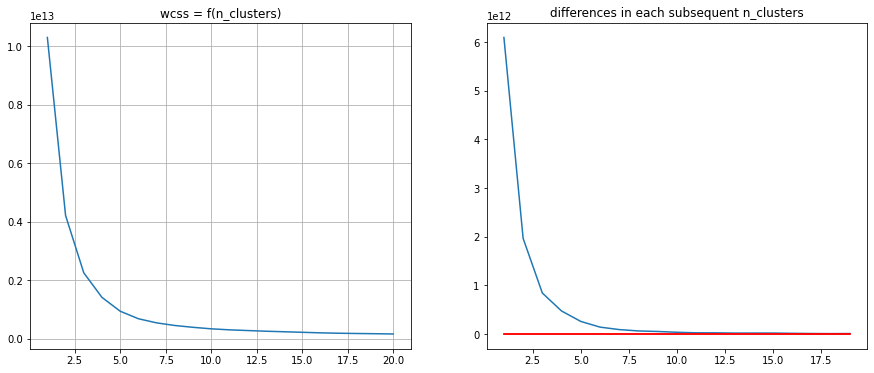

In [4]:
elbow_method.plot(500)

# MySQL

- Upload les bdd depuis pandas vers mysql
- Download les bdd depuis mysql vers python/pandas (permettre l'execution de requête pour importer les bdd)
- ajouter/supprimer des utilisateurs
- mettre à jour les ratings
- mettre à jour les livres

ajouter books.csv, ratings.csv, book_tags.csv, tags.csv<br>
MySQL server on localhost:3307

### test mysql-connector-python

In [6]:
import mysql.connector
from mysql.connector import errorcode

DB_NAME = "book_recommendation_test"
TABLES = {}

TABLES["books"] = (
    "CREATE TABLE books ("
    "book_id INT NOT NULL, "
    "goodreads_book_id INT, "
    "best_book_id INT, "
    "work_id INT, "
    "books_count SMALLINT, "
    "isbn VARCHAR(15), "
    "isbn13 BIGINT, "
    "authors VARCHAR(50), "
    "original_publication_year DECIMAL(5,1), "
    "original_title VARCHAR(100), "
    "title VARCHAR(100), "
    "language_code VARCHAR(10), "
    "average_rating DECIMAL(3,2), "
    "ratings_count INT, "
    "work_ratings_count INT, "
    "work_text_reviews_count INT, "
    "ratings_1 INT, "
    "ratings_2 INT, "
    "ratings_3 INT, "
    "ratings_4 INT, "
    "ratings_5 INT, "
    "PRIMARY KEY book_id,"
    "UNIQUE KEY book_id"
    ")"
)

# TABLES["ratings"] = 

# TABLES["book_tags"] = 

# TABLES["tags"] = 

SyntaxError: invalid syntax (<ipython-input-6-55c16fb71293>, line 11)

### test sqlalchemy

In [17]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# import csv into pandas

df_r = pd.read_csv('databases/ratings.csv')
df_r.sort_values(by="user_id", inplace=True, ignore_index=True)
df_r = df_r.reset_index(drop=True)

df_b = pd.read_csv('databases/books.csv')

df_bt = pd.read_csv('databases/book_tags.csv')

df_t = pd.read_csv('databases/tags.csv')

In [44]:
# Credentials to database connection

hostname="localhost:3307"
dbname="book_recommendation"
uname="root"
pwd="azerty"

# Create SQLAlchemy engine to connect to MySQL Database
engine = create_engine(f"mysql+pymysql://{uname}:{pwd}@{hostname}/{dbname}")
if not database_exists(engine.url):
    print("database doesnt exist")
    create_database(engine.url)
else:
    print("database already exist")

# Convert dataframe to sql table

with engine.begin() as connection:
    
    try:
        df_r.to_sql('ratings', connection, index=False)
        print("ratings uploaded")
    except:
        print("ratings already exists")
    
    try:
        df_b.to_sql('books', connection, index=False)
        print("books uploaded")
    except:
        print("books already exists")
        
    try:
        df_bt.to_sql('book_tags', connection, index=False)
        print("book_tags uploaded")
    except:
        print("book_tags already exists")
        
    try:
        df_t.to_sql('tags', connection, index=False)
        print("tags uploaded")
    except:
        print("tags already exists")

database exist
ratings already exists
books already exists
book_tags already exists
tags already exists


In [47]:
# download dataframes from mysql

hostname="localhost:3307"
dbname="book_recommendation"
uname="root"
pwd="azerty"

engine = create_engine(f"mysql+pymysql://{uname}:{pwd}@{hostname}/{dbname}")

with engine.begin() as connection:
    df_r_2 = pd.read_sql_table("ratings", connection)
    df_b_2 = pd.read_sql_table("books", connection)
    df_bt_2 = pd.read_sql_table("book_tags", connection)
    df_t_2 = pd.read_sql_table("tags", connection)

In [48]:
df_r_2.sample(10)

,user_id,book_id,rating
2180262,18812,8568,3
2124237,18317,40,3
2896358,25133,738,5
1303271,11152,391,3
1133865,9703,5368,3
851819,7301,133,4
2042751,17605,1159,4
3572397,31191,8,5
1956092,16847,429,3
1352598,11573,2422,5


# Dump

In [31]:
df_test = pd.DataFrame.from_dict({"col1": [1,2,3], "col2": [4,5,6]})
data_to_add = pd.DataFrame.from_dict({"col1": [7], "col2": [8]})
df_test = df_test.append(data_to_add)
df_test

,col1,col2
0,1,4
1,2,5
2,3,6
0,7,8


In [62]:
dict_test = {"hahaha": []}
dict_test["hahaha"].append(2)
dict_test["hahaha"]

[2]

In [75]:
series_test = pd.Series(["a", "b", "a", "c", "c"])
test = pd.get_dummies(series_test)
test.melt()

,variable,value
0,a,1
1,a,0
2,a,1
3,a,0
4,a,0
5,b,0
6,b,1
7,b,0
8,b,0
9,b,0


In [3]:
# decorator
def f1(func):
    def wrapper(arg):
        print("function:", func.__name__, "- argument:", arg)
        return func(arg)
    return wrapper

@f1
def f2(x):
    return  x+1

print("result:", f2(1))


function: f2 - argument: 1
result: 2


In [50]:
type(pd.DataFrame.from_dict({"col": [[1,2,3], [1,4,8], [8,4,25]]})["col"][0])

list

In [1]:
import pickle

class ClassTest:
    
    def __init__(self,a,b,c):
        self.a = a
        self.b = b
        self.c = c

In [2]:
import pickle

class ClassTest:
    
    def __init__(self,a,b,c):
        self.a = a
        self.b = b
        self.c = c

with open('test.pickle', 'rb') as pickle_file:
    test = pickle.load(pickle_file)

In [5]:
test.c

3

In [3]:
test = ("hahaha"
       "bababa")
test

'hahahabababa'

In [5]:
test2 = """
hahaha
bababa
"""
test2

'\nhahaha\nbababa\n'